# Quantifying Chaos for a Dynamical System

Topics:
* Introduction to Lyapunov exponents
* Maximum Lyapunov Exponent
* Lyapunov Spectrum

**WARNING** - Compilation of functions in this tutorial takes *a lot of time*.

---

In the previous tutorial we saw that for example the Shinriki oscillator showed something that "could be chaotic behavior" for a specific parameter value. How can we quantify that?

# Lyapunov exponents
* Lyapunov exponents measure the exponential separation rate of trajectories that are (initially) close. 
    * Consider the following picture, where two nearby trajectories are evolved in time:
 


<img src="lyapunov.png" alt="Sketch of the Lyapunov exponent" style="width: 500px;"/>


* $\lambda$ denotes the "maximum Lyapunov exponent".
* A $D$-dimensional system has $D$ exponents.
* In general, a trajectory is called "chaotic" if
    1. it follows nonlinear dynamics
    2. it is *bounded* (does not escape to infinity)
    2. it has a positive Lyapunov exponent

*(please be aware that the above is an over-simplification! See the textbooks cited in our documentation for more)*

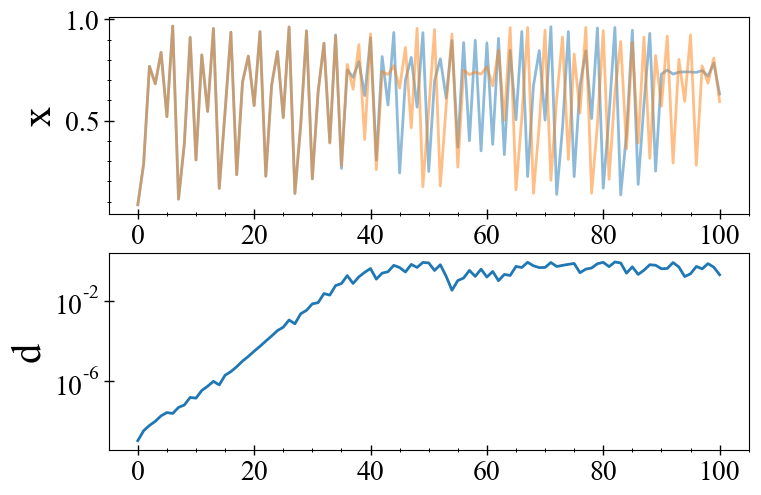

In [1]:
using DynamicalSystems, BenchmarkTools, PyPlot
# Demonstrate the concept of exponential separation using a simple map

# towel map is a pre-defined 3-dimensional hyperchaotic map
# (hyperchaotic means many positive Lyapunov exponents)
# to access pre-defined systems, use the `Systems` module

towel = Systems.towel()
tr1 = trajectory(towel, 100)
# generate a second trajectory, but with starting point close to the original
u2 = state(towel) + (1e-9 * rand(3))
tr2 = trajectory(towel, 100, u2);



figure(figsize=(8,5))

# Plot the x-coordinate of the two trajectories:
ax1 = subplot(2,1,1)
plot(tr1[:, 1], alpha = 0.5)
plot(tr2[:, 1], alpha = 0.5)
ylabel("x")

# Plot their distance in a semilog plot:
ax2 = subplot(2,1,2, sharex = ax1)
d = [norm(tr1[i] - tr2[i]) for i in 1:length(tr2)]
ylabel("d")
semilogy(d);

# Maximum Lyapunov Exponent
`lyapunov` is a function that calculates the maximum Lyapunov exponent for a `DynamicalSystem` (for a given starting point).

Since `lyapunov` is not a trivial function, it is best to read the documentation string first:

In [2]:
?lyapunov

search: lyapunov lyapunovs numericallyapunov



```
lyapunov(ds::DynamicalSystem, Τ; kwargs...) -> λ
```

Calculate the maximum Lyapunov exponent `λ` using a method due to Benettin [1], which simply evolves two neighboring trajectories (one called "given" and one called "test") while constantly rescaling the test one. `T`  denotes the total time of evolution (should be `Int` for discrete systems).

## Keyword Arguments

  * `Ttr = 0` : Extra "transient" time to evolve the trajectories before starting to measure the expontent. Should be `Int` for discrete systems.
  * `d0 = 1e-9` : Initial & rescaling distance between the two neighboring trajectories.
  * `upper_threshold = 1e-6` : Upper distance threshold for rescaling.
  * `lower_threshold = 1e-12` : Lower distance threshold for rescaling (in order to  be able to detect negative exponents).
  * `diff_eq_kwargs = Dict(:abstol=>d0, :reltol=>d0)` : (only for continuous) Keyword arguments passed into the solvers of the `DifferentialEquations` package (see [`trajectory`](@ref) for more info).
  * `dt = 1` : Time of evolution between each check of distance exceeding the thresholds. For continuous systems this is approximate.
  * `inittest = (u1, d0) -> u1 .+ d0/sqrt(D)` : A function that given `(u1, d0)` initializes the test state with distance `d0` from the given state `u1` (`D` is the dimension of the system). This function can be used when you want to avoid the test state appearing in a region of the phase-space where it would have e.g. different energy or escape to infinity.

## Description

Two neighboring trajectories with initial distance `d0` are evolved in time. At time $t_i$ their distance $d(t_i)$ either exceeds the `upper_threshold`, or is lower than `lower_threshold`, which initializes a rescaling of the test trajectory back to having distance `d0` from the given one, while the rescaling keeps the difference vector along the maximal expansion/contraction direction: $u_2 \to u_1+(u_2 - u_1)/(d(t_i)/d_0)$.

The maximum Lyapunov exponent is the average of the time-local Lyapunov exponents

$$
\lambda = \frac{1}{t_{n}}\sum_{i=1}^{n}
\ln\left( a_i \right),\quad a_i = \frac{d(t_{i})}{d_0}.
$$

## Performance Notes

This function uses a `parallel_integrator`. For loops over initial conditions and/or parameter values one should use the lower level methods that accept an integrator, and `reinit!` it to new initial conditions.

See the "advanced documentation" for info on the integrator object and use `@which ...` to go to the source code for the low-level call signature.

## References

[1] : G. Benettin *et al.*, Phys. Rev. A **14**, pp 2338 (1976)


---

Let's apply this to the example of the previous section, the Shinriki oscillator!

* Reminder: we found something that "could" be chaotic behavior for the parameter `R1 = 21.0`



In [3]:
shinriki_voltage(V) = 2.295e-5*(exp(3.0038*V) - exp(-3.0038*V))
function shinriki_eom(u, p, t)
    R1 = p[1]
    du1 = (1/0.01)*(
    u[1]*(1/6.9 - 1/R1) - shinriki_voltage(u[1] - u[2]) - (u[1] - u[2])/14.5
    )
    du2 = (1/0.1)*(
    shinriki_voltage(u[1] - u[2]) + (u[1] - u[2])/14.5 - u[3]
    )
    du3 = (1/0.32)*(-u[3]*0.1 + u[2])
    return SVector{3}(du1, du2, du3)
end

shi = ContinuousDynamicalSystem(shinriki_eom, [-2, 0, 0.2], [21.0])

3-dimensional continuous dynamical system
 state:     [-2.0, 0.0, 0.2]
 e.o.m.:    shinriki_eom
 in-place?  false
 jacobian:  ForwardDiff


In [4]:
lyapunov(shi, 1000.0, Ttr = 10.0)

0.02290509135307459

Positive Lyapunov exponent!?!? That is definitely chaotic behavior, right?

*Right?*

In [5]:
# Increase accuracy of computation, as well as 
# transient time, to see whether an orbit actually enters a limit cycle
lyapunov(shi, 2000.0, Ttr = 1000.0)

-0.0004697804235984747

**BAMBOOZLED**

In [6]:
# Let's find out whats going on!
# Produce a more detailed orbit diagram, around the "critical" 
# value of R = 21.0
pvalues = linspace(20.9,21.1,101)
i = 1
j = 2
tf = 1000.0
p_index = 1

# use extremely long transient time:
output = produce_orbitdiagram(shi, j, i, p_index, pvalues; tfinal = tf,
Ttr = 2000.0, direction = -1, printparams = false);

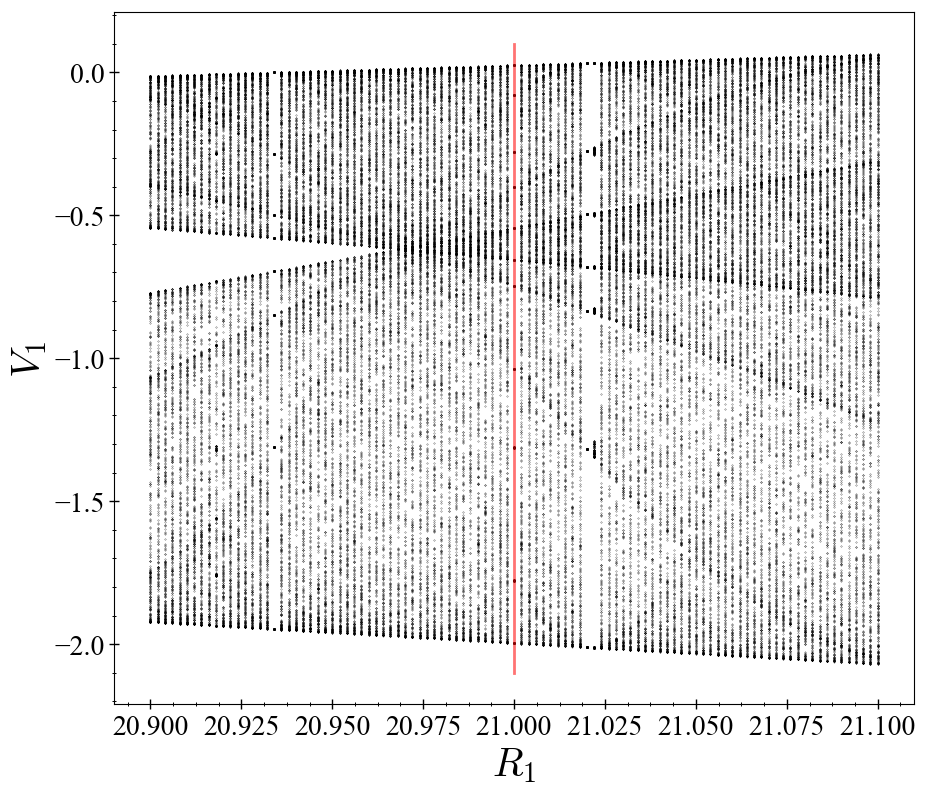

In [7]:
using PyPlot
figure(figsize=(10,8))
for (j, p) in enumerate(pvalues)
    plot(p .* ones(output[j]), output[j], lw = 0,
    marker = "o", ms = 0.2, color = "black")
end
plot([21, 21], [-2.1, 0.1], color = "red", alpha = 0.55)
xlabel("\$R_1\$"); ylabel("\$V_1\$");

In [8]:
# result of orbit diagram at R1 = 21.0
values = output[51] 

# Amount of unique points
un = unique(round.(output[51], 4))
println("Total: $(length(output[51])), unique: $(length(un))")

Total: 758, unique: 20


## `lyapunov` for discrete system

* All functions that accept a `DynamicalSystem` work with *any* instance of `DynamicalSystem`, regardless of whether it is continuous, discrete, in-place, out-of-place or whatever.


In [9]:
# Get the Henon map from the library of pre-defined systems:
hen = Systems.henon()
λ = lyapunov(hen, 10000)

0.4200978623545757

In [10]:
@btime lyapunov($hen, 10000)

  279.994 μs (47 allocations: 3.08 KiB)


0.4200978623545757

---

# Lyapunov Spectrum 

Besides the maximum Laypunov exponent, the function `lyapunovs` (with `s` at the end) returns the entire Lyapunov spectrum (or as many exponents the user wants).



Once again, because the function `lyapunovs` is not trivial, we will view the documentation string first:

In [11]:
?lyapunovs

search: lyapunovs lyapunov numericallyapunov



```
lyapunovs(ds::DynamicalSystem, N, k::Int | Q0; kwargs...) -> λs
```

Calculate the spectrum of Lyapunov exponents [1] of `ds` by applying a QR-decomposition on the parallelepiped matrix `N` times. Return the spectrum sorted from maximum to minimum.

The third argument `k` is optional, and dictates how many lyapunov exponents to calculate (defaults to `dimension(ds)`). Instead of passing an integer `k` you can pass a pre-initialized matrix `Q0` whose columns are initial deviation vectors (then `k = size(Q0)[2]`).

## Keyword Arguments

  * `Ttr = 0` : Extra "transient" time to evolve the system before application of the algorithm. Should be `Int` for discrete systems. Both the system and the deviation vectors are evolved for this time.
  * `dt` : Time of individual evolutions between successive orthonormalization steps. Defaults to `1`. For continuous systems this is approximate.
  * `diff_eq_kwargs = Dict()` : (only for continuous) Keyword arguments passed into the solvers of the `DifferentialEquations` package (see [`trajectory`](@ref) for more info).

## Description

The method we employ is "H2" of [2], originally stated in [3]. The deviation vectors defining a `D`-dimensional parallepiped in tangent space are evolved using the tangent dynamics of the system. A QR-decomposition at each step yields the local growth rate for each dimension of the parallepiped. The growth rates are then averaged over `N` successive steps, yielding the lyapunov exponent spectrum (at each step the parallepiped is re-normalized).

## Performance Notes

This function uses a [`tangent_integrator`](@ref). For loops over initial conditions and/or parameter values one should use the lower level methods that accept an integrator, and `reinit!` it to new initial conditions.

See the "advanced documentation" for info on the integrator object and use `@which ...` to go to the source code for the low-level call signature.

## References

[1] : A. M. Lyapunov, *The General Problem of the Stability of Motion*, Taylor & Francis (1992)

[2] : K. Geist *et al.*, Progr. Theor. Phys. **83**, pp 875 (1990)

[3] : G. Benettin *et al.*, Meccanica **15**, pp 9-20 & 21-30 (1980)


In [12]:
# Example, using discrete

towel = Systems.towel()
lyapunovs(towel, 2000; Ttr = 200)

3-element Array{Float64,1}:
  0.422641
  0.36036 
 -3.27467 

In [13]:
# Compute only first 2 lyapunovs
lyapunovs(towel, 2000, 2; Ttr = 200)

2-element Array{Float64,1}:
 0.422642
 0.36035 

In [14]:
# If you only want the first exponent (maximum)
# use the `lyapunov` function instead
lyapunov(towel, 2000; Ttr = 200)

0.4222043259222616

In [15]:
# How much time does it take?
using BenchmarkTools
@btime lyapunovs($towel, 2000; Ttr = 200);

  401.517 μs (184 allocations: 11.73 KiB)


In [16]:
@btime lyapunov($towel, 2000; Ttr = 200)

  155.187 μs (54 allocations: 3.91 KiB)


0.4222043259222616

## Continuous systems 

In [17]:
# Initialize the lorenz system with random initial condition
lor = Systems.lorenz()

# Compute lyapunovs with specified Q0:
Q0 = eye(3)

lyapunovs(lor, 2000, Q0; Ttr = 10.0)

3-element Array{Float64,1}:
   0.894543  
   0.00114599
 -14.5624    

In [18]:
# Results "converge" already with 2000 iterations:
lyapunovs(lor, 3000, Q0; Ttr = 10.0)

3-element Array{Float64,1}:
   0.895384  
   0.00115214
 -14.5632    

* Even the continuous systems are quite performant (note that compilation takes a **lot** of time):

In [19]:
@btime lyapunovs($lor, 2000, $Q0; Ttr = 10.0);

  134.433 ms (270 allocations: 30.73 KiB)


* The above integration is done with a 9th order solver and tolerances of `1e-9`. But you can get away with lower tolerances:

In [20]:
using OrdinaryDiffEq

# Keyword arguments passed into the integrators of DifferentialEquations.jl
dek = Dict(:solver => Tsit5(), :abstol => 1e-6, :reltol => 1e-6)

# Call lyapunovs with keyword `diff_eq_kwargs`
lyapunovs(lor, 2000.0, Q0; Ttr = 10.0, diff_eq_kwargs = dek)

3-element Array{Float64,1}:
   0.8945    
   0.00146117
 -14.5626    

In [21]:
@btime lyapunovs($lor, 2000.0, $Q0; Ttr = 10.0, diff_eq_kwargs = $dek);

  74.203 ms (280 allocations: 20.41 KiB)
